In [1]:
import torch
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class SquareFunction(torch.nn.Module):
    def __init__(self, Q=torch.FloatTensor([[1.,0.], [0.,1.]]), c=torch.FloatTensor([1.,1.])):
        super(SquareFunction, self).__init__()
        self.num_eval_calls = 0;
        self.c = c;
        self.Q = Q;
        self.x_min = -torch.inverse(Q)@c;
        self.fun_min = self.forward(self.x_min);
        self.x = torch.nn.Parameter(torch.rand(2));
        
    def constraint(self, x):
        return True;
    
    def forward_parameter(self):
        return self.forward(self.x);
    
    def forward(self, x):
        self.num_eval_calls += 1;
        if self.constraint(x):
            f = torch.transpose(x, 0, -1)@((self.Q@x)/2 + self.c);
            return f;
        else:
            return torch.inf;


In [96]:
class GaussianMix(torch.nn.Module):
    def __init__(self, mu1 = torch.FloatTensor([-0.5,-0.5]),mu2 = torch.FloatTensor([0.5,0.5]),sigma = torch.FloatTensor([[0.3,0.], [0.,0.3]])):
        super(GaussianMix, self).__init__()
        self.num_eval_calls = 0;
        self.mu1 = mu1;
        self.mu2 = mu2;
        self.sigma = sigma
        self.x_min = mu2;
        self.fun_min = self.forward(self.x_min);
        self.x = torch.nn.Parameter(torch.rand(2));
        
    def constraint(self, x):
        return True;
    
    def forward_parameter(self):
        return self.forward(self.x);
    
    def forward(self, x):
        self.num_eval_calls += 1;
        if self.constraint(x):
            f = (-(1/(((2*np.pi)**2)*torch.det(self.sigma))**0.5)*torch.exp(-0.5*torch.transpose((x-self.mu1), 0, -1)@torch.inverse(self.sigma)@(x-self.mu1)))+1.5*(-(1/(((2*np.pi)**2)*torch.det(self.sigma))**0.5)*torch.exp(-0.5*torch.transpose(x-self.mu2, 0, -1)@torch.inverse(self.sigma)@(x-self.mu2)))
            return f;
        else:
            return torch.inf;

In [4]:
def DescentOptimizer(fun, opt, init, max_iter=100, eps=1e-5):
    fun.x.data = init;
    x_steps = [init.numpy()];
    y_steps = [fun(init).numpy()];
    f = fun.forward_parameter();
    for i in range(max_iter):
        opt.zero_grad();
        f.backward();
        opt.step();
        f = fun.forward_parameter();
        x_steps.append(copy.deepcopy(fun.x.data.numpy()));
        y_steps.append(f.detach().numpy());
        if (torch.abs(f.data - fun.fun_min) < eps):
            print('Converged with desired accuracy in {} iterations.'.format(i));
            return x_steps, y_steps;
    print('The desired accuracy was not achieved.')
    return x_steps, y_steps;

In [78]:
def visualize_through_numpy(values, func, param):
    for ind in range(len(values)):
        values[ind][0] = np.array(values[ind][0])
        values[ind][1] = np.array(values[ind][1])
    plt.figure(figsize=(18,15));
    plt.tight_layout()
    
    # plot contours
    if param == 'convex':
        X, Y = np.meshgrid(np.linspace(-2, 2, 400), np.linspace(-2, 2, 100))
    else:
        X, Y = np.meshgrid(np.linspace(-1, 1, 400), np.linspace(-1,1, 100))
    Z = np.empty_like(X);
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = fun(torch.FloatTensor([X[i,j], Y[i,j]])).numpy()

    # levels for contour lines
    if param == "convex":
        levels = fun.fun_min.numpy() + np.linspace(0, 3, 10)**2
    else:
        levels = fun.fun_min.numpy() + np.linspace(0, 1, 10)
    ax1 = plt.subplot(2,3,1)
    ax1.plot(fun.x_min[0].numpy(), fun.x_min[1].numpy(), '*')
    ax1.contour(X, Y, Z, levels)
    
    ax2 = plt.subplot(2,3,2)
    ax2.set_title('Function residual')
    ax2.grid()
    
    ax3 = plt.subplot(2,3,3)
    ax3.set_title('Logarithmic function residual')
    ax3.grid()
    
    ax4 = plt.subplot(2,3,4)
    ax4.set_title('Value residual (Euclidean norm)')
    ax4.grid()
    
    ax5 = plt.subplot(2,3,5)
    ax5.set_title('Logarithmic value residual (Euclidean norm)')
    ax5.grid()
    
    # minimum
    for ind in range(len(values)):
        x_steps = values[ind][0]
        y_steps = values[ind][1]
        name = values[ind][2]
        
        # initial point    
        ax1.plot(x_steps[0][0], x_steps[0][1], 'or')
    
        # plot on second image
        ax1.plot(x_steps[:, 0], x_steps[:, 1],'.', label = name)

        # residual f(x_k) - f* 
        f_k_residual = np.abs(fun.fun_min.numpy() - np.array(y_steps));
        N = len(f_k_residual)

        x_k_residual = np.array(x_steps) - fun.x_min.numpy();

        ax2.plot(f_k_residual, label = name)
        
        ax3.plot(np.log(f_k_residual), label = name) 
        
        ax4.plot(np.arange(N), np.linalg.norm(x_k_residual, axis=1), label = name)
        
        ax5.plot(np.arange(N), np.log(np.linalg.norm(x_k_residual, axis=1)), label = name );
        
    ax1.legend()
    ax2.legend()
    ax3.legend()
    ax4.legend()
    ax5.legend()
    plt.show()
    pass

In [90]:
#Convex
fun = SquareFunction(Q=torch.FloatTensor([[1,0],[0,2]]), c=torch.rand(2));

In [91]:
opt_methods=[
    torch.optim.SGD([fun.x], lr=0.01, momentum=0),
    torch.optim.SGD([fun.x], lr=0.01, momentum=0.9),
    torch.optim.SGD([fun.x], lr=0.01, momentum=0.9,nesterov=True),
    torch.optim.Adam([fun.x], lr=0.01),
    torch.optim.Adagrad([fun.x], lr=0.1),
    torch.optim.Adadelta([fun.x], lr=1,), 
    torch.optim.RMSprop([fun.x], lr=0.01)
    
]

In [92]:
opt_names =[
    "SGD",
    "SGD with momentum",
    "SGD with Nesterov momentum",
    "Adam",
    "Adagrad",
    "Adadelta",
    "RMSProp"
]

In [93]:
#Convex
values = []
for name, opt in zip(opt_names, opt_methods):
    x_steps, y_steps = DescentOptimizer(fun, opt, torch.rand(2), max_iter=10000)
    values.append([x_steps, y_steps, name])

Converged with desired accuracy in 541 iterations.
Converged with desired accuracy in 111 iterations.
Converged with desired accuracy in 60 iterations.
Converged with desired accuracy in 262 iterations.
Converged with desired accuracy in 429 iterations.
Converged with desired accuracy in 585 iterations.
Converged with desired accuracy in 203 iterations.


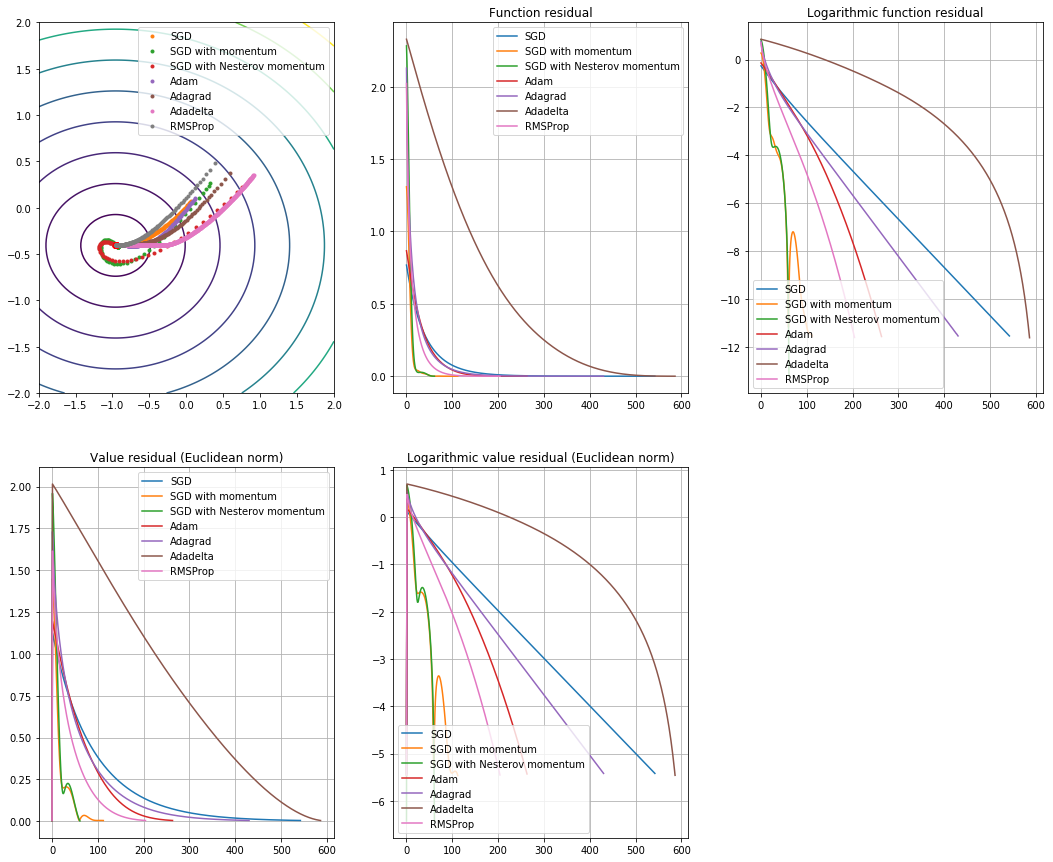

In [94]:
visualize_through_numpy(values, fun, "convex")

In [97]:
#Non-Convex
fun = GaussianMix()
opt_methods=[
    torch.optim.SGD([fun.x], lr=0.01, momentum=0),
    torch.optim.SGD([fun.x], lr=0.01, momentum=0.9),
    torch.optim.SGD([fun.x], lr=0.01, momentum=0.9,nesterov=True),
    torch.optim.Adam([fun.x], lr=0.01),
    torch.optim.Adagrad([fun.x], lr=0.1),
    torch.optim.Adadelta([fun.x], lr=1,), 
    torch.optim.RMSprop([fun.x], lr=0.01)
    
]

In [104]:
#Convex
values = []
init_point = torch.rand(2)
for name, opt in zip(opt_names, opt_methods):
    x_steps, y_steps = DescentOptimizer(fun, opt, torch.rand(2), max_iter=1000)
    values.append([x_steps, y_steps, name])

The desired accuracy was not achieved.
The desired accuracy was not achieved.
The desired accuracy was not achieved.
Converged with desired accuracy in 34 iterations.
The desired accuracy was not achieved.
The desired accuracy was not achieved.
The desired accuracy was not achieved.


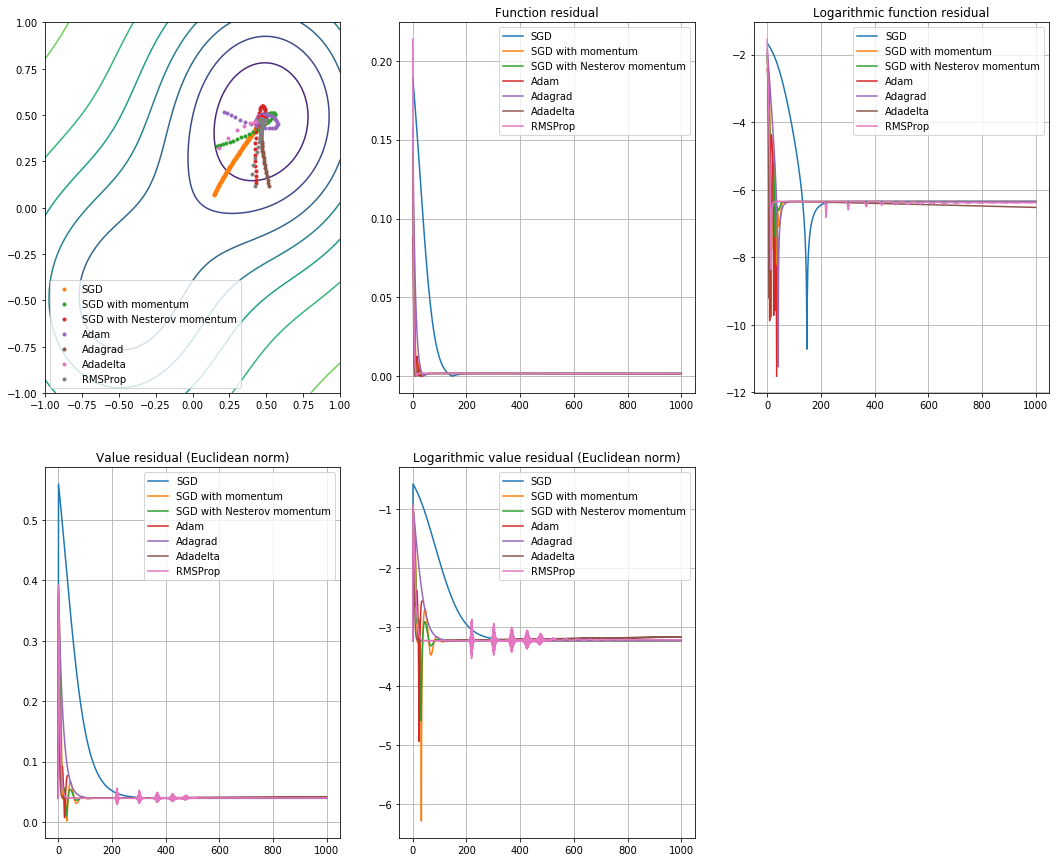

In [105]:
visualize_through_numpy(values, fun, "non-convex")